# Notebook 3 - Inverse design: molecules on specification

By Vincent Blay, December 2021

In this notebook we demonstrate two approaches to the generation of new molecules with a desired property specification by leveraging MACAW embeddings. 

In the first approach we generate a single large library throughout the MACAW embedding space and then retrieve promising molecules using the `hit_finder` functions.

In the second approach we generate a series of small libraries using an evolutionary strategy using the `library_evolver` function.

In both cases, the user is returned a list of promising SMILES molecules and their predicted property values.

In [1]:
import numpy as np
import pandas as pd
import pickle

#Needed to show molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 

import sys
import os
from rdkit import Chem
from rdkit.Chem import RDConfig

sys.path.append('../')
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

import macaw
print(macaw.__version__)

from macaw import *

0.1.14


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
np.random.seed(123)

In this example we will use the RON dataset, so let us load it

In [4]:
df = pd.read_csv('./data/data_RON.csv')
smiles = df.Smiles
Y = df.RON

We will also use the RON property model, so let us load it. In this case we are generating new molecules, so we will not split the dataset

In [5]:
file = open('./results/macaw/RON_model_RVR.pickle', 'rb') 
mcw, regr = pickle.load(file)
file.close()

In [6]:
len(smiles)

194

In [7]:
mcw.transform(list(smiles))

array([[-0.37294356, -0.16228976, -0.11992277, ...,  0.04854571,
         0.15096801, -0.20686424],
       [-0.16341966,  0.09488168, -0.21971061, ..., -0.08187208,
        -0.00823156, -0.12705621],
       [-0.06303536,  0.37059225,  0.37029903, ..., -0.02565884,
         0.02522118, -0.03009937],
       ...,
       [-0.29886838,  0.02393131,  0.03956538, ..., -0.01424329,
        -0.18140393,  0.128053  ],
       [ 0.18440676,  0.20625235,  0.10676658, ..., -0.23138202,
        -0.02068631,  0.10850851],
       [ 0.43964201,  0.20332516,  0.35694922, ..., -0.13639917,
        -0.04441494, -0.0877567 ]])

In [8]:
X = mcw.transform(smiles)

print(np.corrcoef(Y,regr.predict(X))[0,1])

0.9964073927469146


##  Approach 1. Molecular design by generating and screening a single large library

The library generation involves computing a noisy probability matrix from which  molecules will be drawn. Molecules will have a length of up to 20 SELFIES tokens. The method only considers robust SELFIES tokens (i.e., those for which there are state-dependent derivation rules implemented).

In [9]:
smiles_lib = library_maker(smiles, max_len=20, n_gen=200000, algorithm='position', noise_factor=0.5)

10000 molecules generated.
20000 molecules generated.
30000 molecules generated.
40000 molecules generated.
50000 molecules generated.
60000 molecules generated.
70000 molecules generated.
80000 molecules generated.
90000 molecules generated.
100000 molecules generated.
110000 molecules generated.
120000 molecules generated.
130000 molecules generated.
140000 molecules generated.
150000 molecules generated.
160000 molecules generated.
170000 molecules generated.
180000 molecules generated.
190000 molecules generated.
200000 molecules generated.
151916 unique molecules generated.


We first embed the library molecules in the MACAW space:

In [10]:
len(smiles_lib)

151916

In [11]:
X_lib = mcw.transform(smiles_lib)

50000
100000
150000


In [12]:
X_lib.shape

(151916, 15)

And then we find promising molecular designs according to the desired specification (in this example, RON=110). 

For retrieving molecules from the 20-dimensional MACAW space, we will use our custom V-distance metric (`p=0.5`). If not specified, it will use `p=1` by default (Manhattan distance).

In [13]:
spec = 110. # desired RON design specification

idx, Y_hits_pred = hit_finder(X_lib, model=regr, spec=spec, X=X, Y=Y, n_hits=5, k1=5, k2=10, p=0.5, n_rounds=2)
smiles_hits = [smiles_lib[i] for i in idx]

print(smiles_hits)
print(Y_hits_pred)

['[C-]CO', '[C-][C+][O-]', 'CC[PH](=[P+])CC[O-]', 'O=C([C-]P)[P-]C[S+]', 'CCC(C)(C)C(C)C']
[108.38088491 108.38088491 108.57025916 109.17289292 109.54862639]


Let us visualize the molecules:

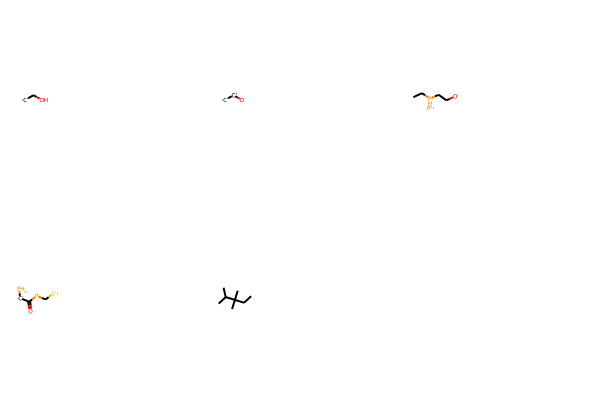

In [14]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

We can double check that we get the desired property specification for the molecules designed:

In [15]:
X_hits = mcw.transform(smiles_hits)
Y_hits_pred = regr.predict(X_hits)
print(Y_hits_pred)

[108.38088491 108.38088491 108.57025916 109.17289292 109.54862639]


Since MACAW embeddings are smooth, we can also use a gradient-based method to navigate the embedding space and retrieve promising molecules. To this end, we use the function `hit_finder_grad`. If we do not provide the arguments `X` (the MACAW embedding of the molecules) or `Y` (property values for the molecules), we may want to increase the parameter `k1` (number of seed molecules to be used in the search).

In [16]:
idx, Y_hits_pred = hit_finder_grad(X_lib, regr, spec, X=X, n_hits=5, k1=100, k2=5)
smiles_hits = [smiles_lib[i] for i in idx]
print(smiles_hits)
print(Y_hits_pred)

['CCC(C)(C)C(C)C', 'C=CC(C)(C)Cl', 'C=C(CBr)COC', 'CP1C[P+]CPC1F', 'COC(=[S+])CC#P=[P+]C[C+]CS']
[109.54862639 109.57906591 110.07009024 110.08961292 110.33734336]


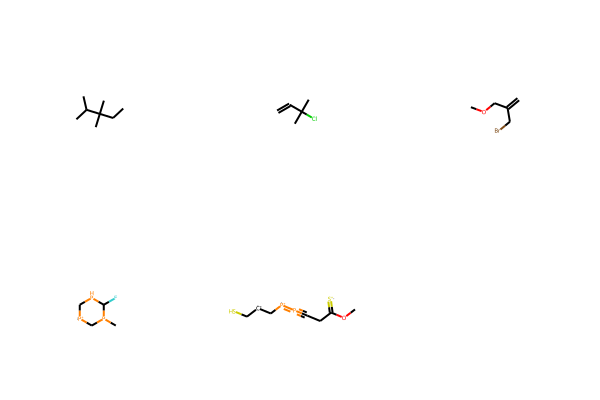

In [17]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

## Approach 2. Molecular design by evolving focused molecular libraries

Let us use MACAW's library evolver to generate molecules with a predicted RON specification of 40. 

By default, `library_evolver` will evolve 8 generations of molecules. This number can be controlled using the optional argument `n_rounds`. With the optional argument `n_hits` we specify the number of molecules that we want the algorithm to return in its output.

In [18]:
%%capture
smiles_hits, Y_hits_pred = library_evolver(smiles, regr, mcw, spec=40., n_hits=5, n_rounds=8)

In [19]:
print(smiles_hits)
print(Y_hits_pred)

['C=CCC[N-]CCCCC#CCC(C)CC', 'CCCCCC#CCCC(CCCCPF)SCCC', 'CC(CC#[O+])CCCCCCS', 'C=[C-]CCCC=[C+]PCCCCCCC(C)PCNPF', 'CCCCCCC=[N-]']
[39.98338668 40.00039454 40.00706591 40.00836729 40.01062488]


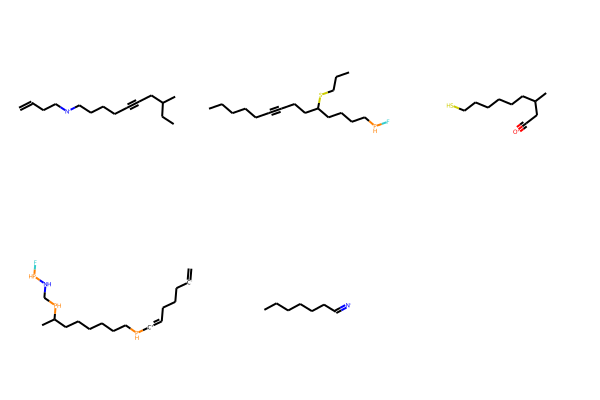

In [20]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

Since we are working with a RVR model, we can also estimate the prediction errors:

In [21]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [22]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)

['C=CCC[N-]CCCCC#CCC(C)CC', 'CCCCCC#CCCC(CCCCPF)SCCC', 'CC(CC#[O+])CCCCCCS', 'C=[C-]CCCC=[C+]PCCCCCCC(C)PCNPF', 'CCCCCCC=[N-]']
[39.98338668 40.00039454 40.00706591 40.00836729 40.01062488]
[3.10199471 3.0868382  3.12468515 3.00143089 3.30378477]


Let us now try to design molecules with a RON design specification of 80:

In [23]:
%%capture
smiles_hits, Y_hits_pred = library_evolver(smiles, regr, mcw, spec=80., n_hits=5)

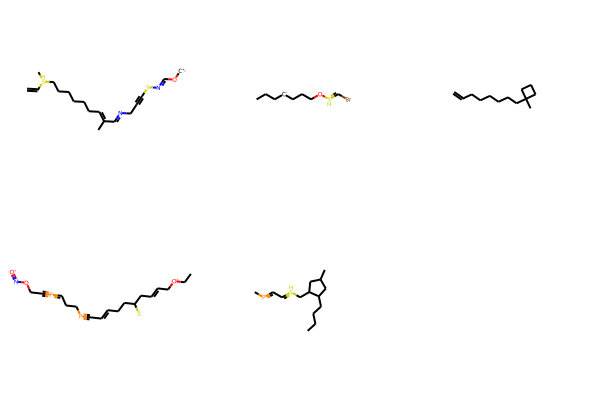

In [24]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

In [25]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [26]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)

['[C+]OC=NSC#CCN=CC(C)=CCCCCCC[SH](C)C=C', 'CCC[C-]CCCO[SH]=CBr', 'C=CCCCCCCC1(C)CCC1', 'CC[O+]CC=CCC([S-])CCC=CC#[P-]CCC=P#CCON=[O+]', 'CCCCC1CC(C)CC1C[SH]=CC=PC']
[79.99764409 79.99977026 80.00012366 80.00119586 80.00440197]
[2.92475196 2.87252118 2.86541747 2.8832036  3.02981123]


Let us now try to design molecules with a RON specification of 120:

In [27]:
%%capture
smiles_hits, Y_hits_pred = library_evolver(smiles, regr, mcw, spec=120., n_hits=5)

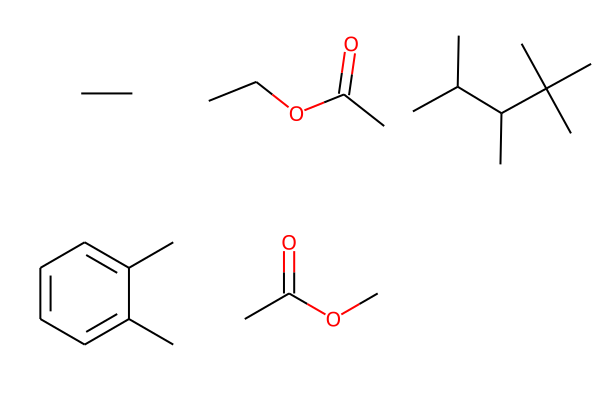

In [28]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

In [29]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [30]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)

['CC', 'CCOC(=O)C', 'CC(C)C(C)C(C)(C)C', 'CC1=CC=CC=C1C', 'CC(=O)OC']
[115.4210643  115.62406096 116.05603511 119.51765992 119.61420727]
[3.59496995 3.50412822 3.59485002 3.82209182 3.65658289]


### Multi-objective optimization in molecular recommendation

We can also design molecules aiming to meet several specifications simultaneously. 

In the next example, we will encourage the recommendation of molecules whose property value is predicted with higher confidence and that have a better Synthetic Accessibility (SA) score. The SA score takes values greater than one, with smaller values indicating better synthetic accessibility. 

We define a custome objective function `f`, which returns a weighted sum of 1) the difference from the desired specification (in this case RON = 40.), 2) the prediction uncertainty, and 3) the SA score. Then we ask the `library_evolver` to try to make it zero, which will minimize the objective function.

In [31]:
def SAscore_calc(smi):
    return [sascorer.calculateScore(Chem.MolFromSmiles(s)) for s in smi]

def F(smi, mcw, setpoint):
    X = mcw.transform(smi)
    Y_pred, Y_pred_std = regr.predict(X, return_std=True)
        
    SAScores = SAscore_calc(smi)
    SAScores = np.array(SAScores)
    
    FO = np.abs(Y_pred - setpoint) + 1.*(Y_pred_std) + 2.*SAScores
    return FO

f = lambda smi: F(smi, mcw, setpoint=120.)

Note that since the function `f` directly featurizes the SMILES molecules itself using `mcw`, we do not need the featurizer when calling `library_evolver` (`mcw=None`):

In [32]:
%%capture
smiles_hits, Y_hits_pred = library_evolver(smiles, f, mcw=None, spec=0., n_hits=5, n_rounds=8)

In [33]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [34]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)
print(SAscore_calc(smiles_hits))

['CC1=CC=CC=C1C', 'CC(=O)OC', 'COC(C)=O', 'CCOC(=O)C', 'CCOC(C)=O']
[119.51765992 119.61420727 119.61420727 115.62406096 115.62406096]
[3.82209182 3.65658289 3.65658289 3.50412822 3.50412822]
[1.0337432953498862, 1.7363164941764762, 1.7363164941764762, 1.7562997790553911, 1.7562997790553911]


The point estimates for the RON of these molecules are not as close to the desired specification as in the design example above, but the prediction errors are smaller and the SA scores are low (close to 1).

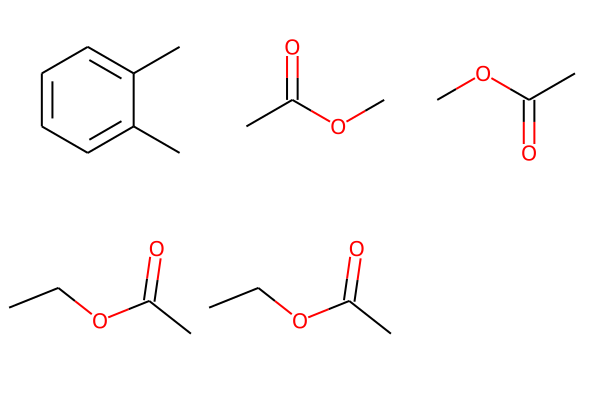

In [35]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)